In [6]:
import ee
import geemap
import folium
import ipywidgets
import ipyleaflet
import pandas as pd
import time

In [6]:
#import sys
#!{sys.executable} -m pip install geemap ipywidgets ipyleaflet folium


  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 5.8 MB/s eta 0:00:00
Using cached jsonpointer-3.0.0-py2.py3-none-any.whl (7.6 kB)
  Attempting uninstall: ipyleaflet
    Found existing installation: ipyleaflet 0.17.4
    Uninstalling ipyleaflet-0.17.4:
      Successfully uninstalled ipyleaflet-0.17.4


In [2]:
# Force re-authentication
ee.Authenticate()

True

In [3]:
# Set Google Earth Engine Project (Replace with your project ID)
PROJECT_ID = "miningcandb"  # Replace with your actual GEE project ID

# Initialize Earth Engine with the project
ee.Initialize(project=PROJECT_ID)

print("✅ Earth Engine is now initialized with project:", PROJECT_ID)

✅ Earth Engine is now initialized with project: miningcandb


### Feature Method
-    .geometry() → Returns the feature’s geometry.
-   .propertyNames() → Lists available properties.
-   .get("property_name") → Gets a specific property.
-   .toDictionary().getInfo() → Converts all feature properties into a Python dictionary.

### Image Methods (for working with raster datasets)
-   .sample() → Samples pixel values at given points.
-   .reduceRegion() → Aggregates values over a specific area.
-   .clip(geometry) → Clips the raster to a defined region.

### Filtering and reducing data 
- .filterBounds(geometry) → Returns only features within a given boundary.
- .filterMetadata("property", "equals", value) → Filters by attribute value.

In [ ]:
dataset = ee.FeatureCollection("WRI/Aqueduct_Water_Risk/V4/baseline_annual")
# Get first features
first_feature = dataset.first().toDictionary().getInfo()
print(first_feature)
# Get available property names
properties = dataset.first().propertyNames().getInfo()
print("Available properties:", properties)
# Get dictionary of the first feature
first_feature = dataset.first().toDictionary().getInfo()

# Print all key-value pairs
for key, value in first_feature.items():
    print(f"{key}: {value}")


# Maps 

In [4]:
# Does not display in PyCharm because of missing widget support 
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
# Instead we can use folium or ipyleaflet 
m = folium.Map(location=[46.5, -81.0], zoom_start=6)
folium.Marker([46.5, -81.0], popup="Sudbury Mining Site").add_to(m)
m

# Extract data 

In [21]:
facility_df = pd.read_csv(r'data/Tables/facility_df.csv')
facility_df

,facility_id,facility_name,reported_company,latitude,longitude,geometry,city,province,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source,source_df,operating_periods
0,QC-MIN-2794515439,Sleeping Giant,Abcourt Mines Inc.,49.132590,-77.974340,POLYGON ((-77.90825051690989 49.12067049588597...,north of Amos,Quebec,mining,Concentrator,Precious metals,Gold,"Gold, silver",NaN,nrcan_mining_df,"1956-1959, 1974-1975, 1988-Present"
1,NU-MIN-2679673302,Amaruq,Agnico Eagle Mines Limited,65.415000,-96.697000,POLYGON ((-96.58600443455364 65.41619338061454...,Baker Lake,Nunavut,mining,"Open-pit, underground",Precious metals,Gold,Gold,NaN,nrcan_mining_df,2019-Present
2,QC-MIN-2627031709,Canadian Malartic,Agnico Eagle Mines Limited,48.122223,-78.130824,POLYGON ((-78.06625549795169 48.11045584785048...,Malartic,Quebec,mining,"Open-pit, concentrator",Precious metals,Gold,"Gold, silver",NaN,nrcan_mining_df,"2011-Present, 2011-Present, 2019-Present"
3,ON-MIN-2988880345,Detour Lake,Agnico Eagle Mines Limited,50.018143,-79.717631,POLYGON ((-79.64962758031054 50.00738190580976...,Northeast of Cochrane,Ontario,mining,"Open-pit, concentrator",Precious metals,Gold,Gold,NaN,nrcan_mining_df,2013-Present
4,QC-MIN-269136753,Goldex,Agnico Eagle Mines Limited,48.092600,-77.873300,POLYGON ((-77.80884811810205 48.08065931489108...,Val-d’Or,Quebec,mining,"Underground, concentrator",Precious metals,Gold,"Gold, silver",NaN,nrcan_mining_df,"1936-1996, 2005-2013, 2021-Present"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,BC-MAN-3012997128,Victoria Depot,Radius Recyling,48.437320,-123.376920,POLYGON ((-123.31606676800574 48.4566597826742...,NaN,British Columbia,manufacturing,NaN,NaN,NaN,NaN,NaN,nrcan_manufacturing_df,NaN
182,ON-MAN-392691787,Welland Mill,Valbruna ASW Inc.,42.998265,-79.235065,"POLYGON ((-79.1772336671633 42.98750160115429,...",NaN,Ontario,manufacturing,Electric arc furnace,Iron ore,Steel,Steel,NaN,nrcan_manufacturing_df,NaN
183,SK-MAN-62454262,Wheat City Metals Inc.,EVRAZ North America Inc.,50.525046,-104.639712,POLYGON ((-104.56960375645319 50.5318458692246...,NaN,Saskatchewan,manufacturing,NaN,NaN,NaN,NaN,NaN,nrcan_manufacturing_df,NaN
184,ON-MAN-3507150858,Whitby Division,Gerdau Corporation,43.851906,-78.910676,POLYGON ((-78.85184721950843 43.84087955305477...,NaN,Ontario,manufacturing,NaN,NaN,NaN,NaN,NaN,nrcan_manufacturing_df,NaN


In [ ]:
countries = ee.FeatureCollection("put your dataset ID")
roi = countries.filter(ee.Filter.eq('countr_na', 'Swaziland'))
Map.addLayer(roi, {}, 'Canada')
Map.centerObject(roi, 8);
Map

landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_L2').filterDate('2016-01-01', '2016-12-31').filterBounds(roi)

# Remove clouds
composite = ee.Algorithms.

## Air pollution

### Function to extract data 

In [30]:
def extract_pollution_data(facility_df, start_date="2023-01-01", end_date="2023-12-31"):
    """
    Extracts air pollution data (SO₂, NO₂, CO, PM2.5) from Sentinel-5P for given facilities and prints execution time.

    Parameters:
    - facility_df (pd.DataFrame): DataFrame with columns ['facility_id', 'facility_name', 'latitude', 'longitude']
    - start_date (str): Start date for data extraction (format: "YYYY-MM-DD")
    - end_date (str): End date for data extraction (format: "YYYY-MM-DD")

    Returns:
    - pollution_df (pd.DataFrame): DataFrame with pollution data for each facility with mean data for the selected date
    """
    start_time = time.time()

    # Ensure required columns exist
    required_cols = {"facility_id", "facility_name", "latitude", "longitude"}
    if not required_cols.issubset(facility_df.columns):
        raise ValueError(f"Missing required columns in facility_df: {required_cols - set(facility_df.columns)}")

    # Define Sentinel-5P datasets for pollutants and their units
    pollutant_bands = {
        "SO2": ("COPERNICUS/S5P/OFFL/L3_SO2", "SO2_column_number_density", "mol/m²"),  # Moles per square meter
        "NO2": ("COPERNICUS/S5P/OFFL/L3_NO2", "NO2_column_number_density", "mol/m²"),
        "CO": ("COPERNICUS/S5P/OFFL/L3_CO", "CO_column_number_density", "mol/m²"),
        "O3": ("COPERNICUS/S5P/OFFL/L3_O3", "O3_column_number_density", "mol/m²"),
        "PM2.5": ("COPERNICUS/S5P/NRTI/L3_AER_AI", "absorbing_aerosol_index", "unitless"),  # Aerosol Index (AI)
        "CH4": ("COPERNICUS/S5P/OFFL/L3_CH4", "CH4_column_volume_mixing_ratio_dry_air", "ppb"),
        
    }

    # Store results
    results = []

    # Process each facility
    for index, row in facility_df.iterrows():
        facility_id = row["facility_id"]
        facility_name = row["facility_name"]
        lat, lon = row["latitude"], row["longitude"]
        facility_location = ee.Geometry.Point([lon, lat])

        # Store extracted values
        facility_data = {
            "facility_id": facility_id,
            "facility_name": facility_name,
            "latitude": lat,
            "longitude": lon
        }

        # Extract pollution data for each pollutant
        for pollutant, (dataset, band, unit) in pollutant_bands.items():
            try:
                # Load dataset, filter by date and location
                pollution_data = (ee.ImageCollection(dataset)
                                  .filterBounds(facility_location)
                                  .filterDate(start_date, end_date)
                                  .select(band)
                                  .mean())  # Compute average over the period

                # Reduce region to extract pollution value at the facility location
                pollution_value = pollution_data.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=facility_location,
                    scale=5000,  # 5 km resolution for most pollutants
                    bestEffort=True
                ).get(band)

                # Convert Earth Engine object to Python
                facility_data[pollutant] = pollution_value.getInfo() if pollution_value else None
                facility_data[f"{pollutant}_unit"] = unit  # Add unit
            except Exception as e:
                facility_data[pollutant] = None  # Handle cases where no data is available
                facility_data[f"{pollutant}_unit"] = unit

        # Append results
        results.append(facility_data)

        # Progress tracking
        if index % 10 == 0:
            print(f"Processed {index + 1}/{len(facility_df)} facilities...")

    # Compute total execution time
    total_time = time.time() - start_time
    print(f"✅ Extraction completed in {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

    # Convert results to DataFrame
    pollution_df = pd.DataFrame(results)

    return pollution_df

In [31]:
pollution_df = extract_pollution_data(facility_df)

Processed 1/186 facilities...
Processed 11/186 facilities...
Processed 21/186 facilities...
Processed 31/186 facilities...
Processed 41/186 facilities...
Processed 51/186 facilities...
Processed 61/186 facilities...
Processed 71/186 facilities...
Processed 81/186 facilities...
Processed 91/186 facilities...
Processed 101/186 facilities...
Processed 111/186 facilities...
Processed 121/186 facilities...
Processed 131/186 facilities...
Processed 141/186 facilities...
Processed 151/186 facilities...
Processed 161/186 facilities...
Processed 171/186 facilities...
Processed 181/186 facilities...
✅ Extraction completed in 1923.17 seconds (32.05 minutes)


In [46]:
def format_pollution_for_table(df):
    """
    Reformats the pollution DataFrame by merging the unit information into column names
    and removing unnecessary '_unit' columns. Includes debugging steps.
    """
    new_columns = {}
    unit_columns = [col for col in df.columns if col.endswith("_unit")]
    
    # Iterate through columns and match pollutant columns with their unit columns
    for col in df.columns:
        if col.endswith("_unit"):
            pollutant = col.replace("_unit", "")
            if pollutant in df.columns:
                # Rename main pollutant column with unit in parentheses
                unit_value = df[col].iloc[0] if pd.notna(df[col].iloc[0]) else "unknown_unit"
                new_columns[pollutant] = f"{pollutant} ({unit_value})"
            new_columns[col] = None  # Mark for removal
        else:
            if col not in new_columns:
                new_columns[col] = col  # Keep unchanged columns

    # Apply renaming and drop unnecessary columns
    formatted_df = df.rename(columns={k: v for k, v in new_columns.items() if v is not None})
    
    # Drop '_unit' columns if they exist in the DataFrame
    formatted_df = formatted_df.drop(columns=[col for col in unit_columns if col in formatted_df.columns], errors="ignore")
    
    return formatted_df

In [47]:
pollution_df = format_pollution_for_table(pollution_df)
pollution_df

,facility_id,facility_name,latitude,longitude,SO2 (mol/m²),NO2 (mol/m²),CO (mol/m²),O3 (mol/m²),PM2.5 (unitless),CH4 (ppb)
0,QC-MIN-2794515439,Sleeping Giant,49.132590,-77.974340,0.000181,0.000057,0.035747,0.156268,-0.354801,1864.404513
1,NU-MIN-2679673302,Amaruq,65.415000,-96.697000,0.000049,0.000063,0.035097,0.163425,-0.053153,1869.272390
2,QC-MIN-2627031709,Canadian Malartic,48.122223,-78.130824,0.000304,0.000062,0.036188,0.154863,-0.319769,1869.596698
3,ON-MIN-2988880345,Detour Lake,50.018143,-79.717631,0.000180,0.000059,0.035943,0.157210,-0.217683,1882.346927
4,QC-MIN-269136753,Goldex,48.092600,-77.873300,0.000155,0.000059,0.036237,0.154711,-0.312346,1877.597566
...,...,...,...,...,...,...,...,...,...,...
181,BC-MAN-3012997128,Victoria Depot,48.437320,-123.376920,0.000367,0.000087,0.034778,0.152405,-0.280615,1882.591150
182,ON-MAN-392691787,Welland Mill,42.998265,-79.235065,0.000270,0.000097,0.037530,0.147979,-0.313880,1890.272585
183,SK-MAN-62454262,Wheat City Metals Inc.,50.525046,-104.639712,0.000044,0.000075,0.034166,0.152378,-0.193131,1883.318476
184,ON-MAN-3507150858,Whitby Division,43.851906,-78.910676,0.000226,0.000105,0.039201,0.149703,-0.318829,1893.122224


In [48]:
pollution_df.to_csv(r'data/Satellite_outputs/tropomi_2023.csv', index=False)

In [60]:
pollution_df.columns

Index(['id', 'facility_id', 'facility_name', 'latitude', 'longitude',
       'SO2 (mol/m²)', 'NO2 (mol/m²)', 'CO (mol/m²)', 'O3 (mol/m²)',
       'PM2.5 (unitless)', 'CH4 (ppb)'],
      dtype='object')

In [7]:
pollution_df = pd.read_csv(r'data/Satellite_outputs/tropomi_2023.csv')

In [8]:
pollution_df

,facility_id,facility_name,latitude,longitude,SO2 (mol/m²),NO2 (mol/m²),CO (mol/m²),O3 (mol/m²),PM2.5 (unitless),CH4 (ppb)
0,QC-MIN-2794515439,Sleeping Giant,49.132590,-77.974340,0.000181,0.000057,0.035747,0.156268,-0.354801,1864.404513
1,NU-MIN-2679673302,Amaruq,65.415000,-96.697000,0.000049,0.000063,0.035097,0.163425,-0.053153,1869.272390
2,QC-MIN-2627031709,Canadian Malartic,48.122223,-78.130824,0.000304,0.000062,0.036188,0.154863,-0.319769,1869.596698
3,ON-MIN-2988880345,Detour Lake,50.018143,-79.717631,0.000180,0.000059,0.035943,0.157210,-0.217683,1882.346927
4,QC-MIN-269136753,Goldex,48.092600,-77.873300,0.000155,0.000059,0.036237,0.154711,-0.312346,1877.597566
...,...,...,...,...,...,...,...,...,...,...
181,BC-MAN-3012997128,Victoria Depot,48.437320,-123.376920,0.000367,0.000087,0.034778,0.152405,-0.280615,1882.591150
182,ON-MAN-392691787,Welland Mill,42.998265,-79.235065,0.000270,0.000097,0.037530,0.147979,-0.313880,1890.272585
183,SK-MAN-62454262,Wheat City Metals Inc.,50.525046,-104.639712,0.000044,0.000075,0.034166,0.152378,-0.193131,1883.318476
184,ON-MAN-3507150858,Whitby Division,43.851906,-78.910676,0.000226,0.000105,0.039201,0.149703,-0.318829,1893.122224


In [ ]:
# --- FIX PM2.5 NEGATIVE VALUES ---
pollution_df["PM2.5 (unitless)"] = pollution_df["PM2.5 (unitless)"].clip(lower=0)
pollution_df

### Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import folium
import branca.colormap as cm
from shapely.geometry import Point

In [27]:
# --- FUNCTION FOR POLLUTION MAP WITH REGULATION-BASED THRESHOLDS ---
def visualize_pollution_map_thresholds(pollution_df, pollutant_key):
    """
    Creates an interactive map with pollution data using regulatory-based thresholds.
    
    Parameters:
    - pollution_df (pd.DataFrame): DataFrame with pollution values.
    - pollutant_key (str): The column name representing the pollutant to visualize.
    
    Returns:
    - Folium map with pollution data visualization.
    """
    if pollutant_key not in pollution_df.columns:
        raise ValueError(f"Pollutant '{pollutant_key}' not found in dataframe columns: {pollution_df.columns.tolist()}")
    
    # Define map center
    map_center = [pollution_df["latitude"].mean(), pollution_df["longitude"].mean()]
    m = folium.Map(location=map_center, zoom_start=5, control_scale=True)
    
    # Define thresholds based on regulatory values
    thresholds = {
        "SO2 (mol/m²)": [0.0002, 0.0005],  # Example values based on air quality guidelines
        "NO2 (mol/m²)": [0.0001, 0.0003],
        "CO (mol/m²)": [0.03, 0.05],
        "O3 (mol/m²)": [0.15, 0.2],
        "PM2.5 (unitless)": [5, 15],  # Placeholder values, adjust based on standards
        "CH4 (ppb)": [1850, 1900]  # Placeholder values for methane concentration
    }
    
    def get_regulatory_color(value, pollutant):
        if pd.isna(value):
            return "gray"
        limits = thresholds.get(pollutant, [float("inf"), float("inf")])
        if value < limits[0]:
            return "green"
        elif value < limits[1]:
            return "yellow"
        else:
            return "red"
    
    for _, row in pollution_df.iterrows():
        popup_info = f"""
        <b>{row["facility_name"]}</b><br>
        {pollutant_key}: {row.get(pollutant_key, "N/A")}
        """
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=5,
            color=get_regulatory_color(row[pollutant_key], pollutant_key),
            fill=True,
            fill_color=get_regulatory_color(row[pollutant_key], pollutant_key),
            fill_opacity=0.8,
            popup=folium.Popup(popup_info, max_width=300)
        ).add_to(m)
    return m

# --- FUNCTION FOR POLLUTION MAP WITH CONTINUOUS COLOR SCALE ---
def visualize_pollution_map_continuous(pollution_df, pollutant_key):
    """
    Creates an interactive map with pollution data using a continuous color scale.
    
    Parameters:
    - pollution_df (pd.DataFrame): DataFrame with pollution values.
    - pollutant_key (str): The column name representing the pollutant to visualize.
    
    Returns:
    - Folium map with pollution data visualization.
    """
    if pollutant_key not in pollution_df.columns:
        raise ValueError(f"Pollutant '{pollutant_key}' not found in dataframe columns: {pollution_df.columns.tolist()}")
    
    # Define map center
    map_center = [pollution_df["latitude"].mean(), pollution_df["longitude"].mean()]
    m = folium.Map(location=map_center, zoom_start=5, control_scale=True)
    
    # Define continuous color scale correctly
    min_pollution = pollution_df[pollutant_key].min()
    max_pollution = pollution_df[pollutant_key].max()
    colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=min_pollution, vmax=max_pollution)
    
    for _, row in pollution_df.iterrows():
        popup_info = f"""
        <b>{row["facility_name"]}</b><br>
        {pollutant_key}: {row.get(pollutant_key, "N/A")}
        """
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=5,
            color=colormap(row[pollutant_key]),
            fill=True,
            fill_color=colormap(row[pollutant_key]),
            fill_opacity=0.8,
            popup=folium.Popup(popup_info, max_width=300)
        ).add_to(m)
    
    colormap.add_to(m)
    return m

In [30]:
visualize_pollution_map_continuous(pollution_df, pollutant_key="NO2 (mol/m²)")

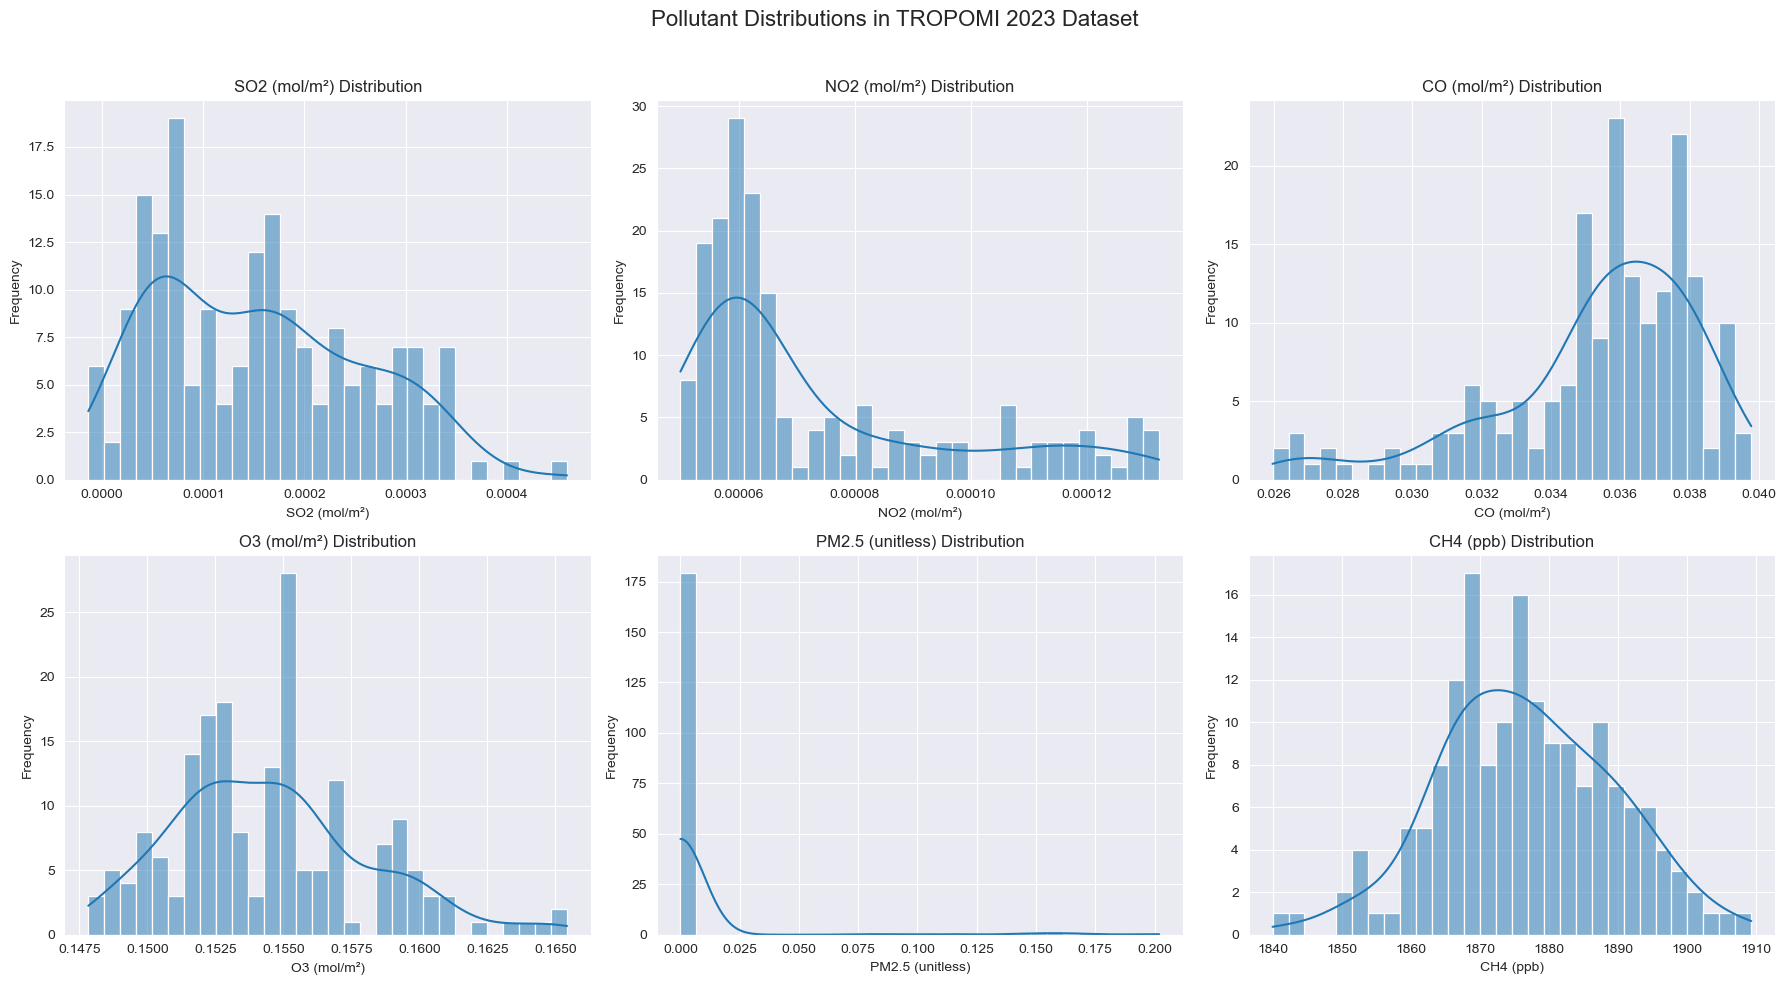

In [31]:
# --- HISTOGRAM VISUALIZATION ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Pollutant Distributions in TROPOMI 2023 Dataset", fontsize=16)

# List of pollutants
pollutants = ["SO2 (mol/m²)", "NO2 (mol/m²)", "CO (mol/m²)", "O3 (mol/m²)", "PM2.5 (unitless)", "CH4 (ppb)"]

# Plot histograms for each pollutant
for ax, pollutant in zip(axes.flatten(), pollutants):
    sns.histplot(pollution_df[pollutant].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title(f"{pollutant} Distribution")
    ax.set_xlabel(pollutant)
    ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:

# --- SPATIAL VISUALIZATION OF SO2 LEVELS ---
# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(pollution_df["longitude"], pollution_df["latitude"])]
geo_df = gpd.GeoDataFrame(pollution_df, geometry=geometry, crs="EPSG:4326")

# Plot SO2 levels spatially
fig, ax = plt.subplots(figsize=(12, 8))
geo_df.plot(column="SO2 (mol/m²)", cmap="Reds", markersize=50, alpha=0.7, legend=True, ax=ax)
ax.set_title("Spatial Distribution of SO₂ Levels (mol/m²) at Mining Facilities", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [49]:
from db_creation_function import assign_row_id

In [50]:
pollution_satellite_df = assign_row_id(pollution_df, id_column='id', prefix='pollution_satellite')

In [52]:
pollution_df.to_csv(r'data/Tables/tropomi_table.csv', index=False)

## Land cover

In [55]:
def extract_land_cover(facility_df, years=[2023], quarters=False):
    """
    Extracts land cover data from ESA WorldCover (yearly) and Dynamic World (optional quarterly) for given facilities.

    Parameters:
    - facility_df (pd.DataFrame): DataFrame with columns ['facility_id', 'facility_name', 'latitude', 'longitude']
    - years (list): List of years to extract data for (default: [2023])
    - quarters (bool): If True, extract Dynamic World data quarterly instead of yearly.

    Returns:
    - land_cover_df (pd.DataFrame): DataFrame with land cover information for each facility.
    """
    start_time = time.time()

    # Ensure required columns exist
    required_cols = {"facility_id", "facility_name", "latitude", "longitude"}
    if not required_cols.issubset(facility_df.columns):
        raise ValueError(f"Missing required columns in facility_df: {required_cols - set(facility_df.columns)}")

    # Store results
    results = []

    # Process each facility
    for index, row in facility_df.iterrows():
        facility_id = row["facility_id"]
        facility_name = row["facility_name"]
        lat, lon = row["latitude"], row["longitude"]
        facility_location = ee.Geometry.Point([lon, lat])

        # Store extracted values
        facility_data = {
            "facility_id": facility_id,
            "facility_name": facility_name,
            "latitude": lat,
            "longitude": lon
        }

        # Extract ESA WorldCover data (yearly updates)
        for year in years:
            try:
                dataset = f"ESA/WorldCover/v100/{year}"
                band = "Map"

                # Load dataset and extract land cover classification
                land_cover_image = ee.ImageCollection(dataset).filterBounds(facility_location).first()
                land_cover_value = land_cover_image.reduceRegion(
                    reducer=ee.Reducer.mode(),
                    geometry=facility_location,
                    scale=10,
                    bestEffort=True
                ).get(band)

                # Convert EE object to Python
                facility_data[f"ESA_WorldCover_{year}"] = land_cover_value.getInfo() if land_cover_value else None
            except Exception:
                facility_data[f"ESA_WorldCover_{year}"] = None

        # Extract Dynamic World land cover data (quarterly or yearly)
        for year in years:
            if quarters:
                # Extract quarterly data
                for quarter, month in enumerate([1, 4, 7, 10], start=1):
                    try:
                        dataset = "GOOGLE/DYNAMICWORLD/V1"
                        band = "label"

                        start_date = f"{year}-{str(month).zfill(2)}-01"
                        end_date = f"{year}-{str(month + 2).zfill(2)}-28"

                        land_cover_image = ee.ImageCollection(dataset) \
                            .filterBounds(facility_location) \
                            .filterDate(start_date, end_date) \
                            .first()

                        land_cover_value = land_cover_image.reduceRegion(
                            reducer=ee.Reducer.mode(),
                            geometry=facility_location,
                            scale=10,
                            bestEffort=True
                        ).get(band)

                        # Convert EE object to Python
                        facility_data[f"Dynamic_World_{year}_Q{quarter}"] = land_cover_value.getInfo() if land_cover_value else None
                    except Exception:
                        facility_data[f"Dynamic_World_{year}_Q{quarter}"] = None
            else:
                # Extract yearly Dynamic World data
                try:
                    dataset = "GOOGLE/DYNAMICWORLD/V1"
                    band = "label"

                    start_date = f"{year}-01-01"
                    end_date = f"{year}-12-31"

                    land_cover_image = ee.ImageCollection(dataset) \
                        .filterBounds(facility_location) \
                        .filterDate(start_date, end_date) \
                        .first()

                    land_cover_value = land_cover_image.reduceRegion(
                        reducer=ee.Reducer.mode(),
                        geometry=facility_location,
                        scale=10,
                        bestEffort=True
                    ).get(band)

                    # Convert EE object to Python
                    facility_data[f"Dynamic_World_{year}"] = land_cover_value.getInfo() if land_cover_value else None
                except Exception:
                    facility_data[f"Dynamic_World_{year}"] = None

        # Append results
        results.append(facility_data)

        # Progress tracking
        if index % 10 == 0:
            print(f"Processed {index + 1}/{len(facility_df)} facilities...")

    # Compute total execution time
    total_time = time.time() - start_time
    print(f"✅ Land cover extraction completed in {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

    # Convert results to DataFrame
    land_cover_df = pd.DataFrame(results)

    return land_cover_df

In [57]:
land_cover_2023_df = extract_land_cover(facility_df, years=[2021], quarters=False)
land_cover_2023_df

Processed 1/186 facilities...
Processed 11/186 facilities...
Processed 21/186 facilities...
Processed 31/186 facilities...
Processed 41/186 facilities...
Processed 51/186 facilities...
Processed 61/186 facilities...
Processed 71/186 facilities...
Processed 81/186 facilities...
Processed 91/186 facilities...
Processed 101/186 facilities...
Processed 111/186 facilities...
Processed 121/186 facilities...
Processed 131/186 facilities...
Processed 141/186 facilities...
Processed 151/186 facilities...
Processed 161/186 facilities...
Processed 171/186 facilities...
Processed 181/186 facilities...
✅ Land cover extraction completed in 98.29 seconds (1.64 minutes)


,facility_id,facility_name,latitude,longitude,ESA_WorldCover_2021,Dynamic_World_2021
0,QC-MIN-2794515439,Sleeping Giant,49.132590,-77.974340,None,8.0
1,NU-MIN-2679673302,Amaruq,65.415000,-96.697000,None,8.0
2,QC-MIN-2627031709,Canadian Malartic,48.122223,-78.130824,None,8.0
3,ON-MIN-2988880345,Detour Lake,50.018143,-79.717631,None,NaN
4,QC-MIN-269136753,Goldex,48.092600,-77.873300,None,8.0
...,...,...,...,...,...,...
181,BC-MAN-3012997128,Victoria Depot,48.437320,-123.376920,None,NaN
182,ON-MAN-392691787,Welland Mill,42.998265,-79.235065,None,NaN
183,SK-MAN-62454262,Wheat City Metals Inc.,50.525046,-104.639712,None,8.0
184,ON-MAN-3507150858,Whitby Division,43.851906,-78.910676,None,NaN


In [ ]:
from db_creation_function import assign_row_id

In [ ]:
# Re-load required libraries after execution state reset
import pandas as pd
import ace_tools as tools

# Define satellite dataset information
satellite_data = [
    {
        "Satellite": "Sentinel-2 (ESA Copernicus)",
        "Resolution": "10m (RGB, NIR), 20m (other bands)",
        "Frequency": "Every 5 days",
        "Best For": "Land cover, vegetation, mining areas, urbanization",
        "GEE Dataset Link": "https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2"
    },
    {
        "Satellite": "Landsat 8 & 9 (NASA/USGS)",
        "Resolution": "30m (multispectral), 15m (panchromatic)",
        "Frequency": "Every 16 days",
        "Best For": "General land-use changes, historical mining analysis",
        "GEE Dataset Link": "https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_TOA"
    },
    {
        "Satellite": "MODIS (NASA)",
        "Resolution": "250m (bands 1-2), 500m (other bands)",
        "Frequency": "Daily",
        "Best For": "Large-scale air pollution (PM, CO, NO₂), biomass burning",
        "GEE Dataset Link": "https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1"
    },
    {
        "Satellite": "VIIRS (NASA/NOAA)",
        "Resolution": "750m – 1km",
        "Frequency": "Daily",
        "Best For": "Nighttime lights, wildfire detection, emissions tracking",
        "GEE Dataset Link": "https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMCFG"
    },
    {
        "Satellite": "TROPOMI (Sentinel-5P)",
        "Resolution": "5.5 km × 3.5 km",
        "Frequency": "Daily",
        "Best For": "Air pollution (SO₂, NO₂, CO, CH₄), industrial emissions tracking",
        "GEE Dataset Link": "https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2"
    },
    {
        "Satellite": "GHGSat (Commercial)",
        "Resolution": "~25m (Methane monitoring)",
        "Frequency": "Variable",
        "Best For": "High-resolution CH₄ emissions from industrial sources",
        "GEE Dataset Link": "Not available (commercial data)"
    },
    {
        "Satellite": "ECOSTRESS (NASA)",
        "Resolution": "70m",
        "Frequency": "Variable",
        "Best For": "Thermal imaging, industrial heat emissions, energy use analysis",
        "GEE Dataset Link": "https://developers.google.com/earth-engine/datasets/catalog/NASA_ECO1_LSTE_V001"
    },
    {
        "Satellite": "ASTER (NASA)",
        "Resolution": "15m (VNIR), 30m (SWIR), 90m (TIR)",
        "Frequency": "On-demand",
        "Best For": "Mineral mapping, geothermal monitoring",
        "GEE Dataset Link": "https://developers.google.com/earth-engine/datasets/catalog/ASTER_GED_V3"
    }
]

# Convert to DataFrame
satellite_df = pd.DataFrame(satellite_data)

# Display the table
tools.display_dataframe_to_user(name="LCA-Related Satellite Datasets", dataframe=satellite_df)
